In [1]:
import argparse
import torch
import torch.nn as nn
import utils
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

/store/DAMTP/na673/mamba/envs/lion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fwd_gradients(obj, x):
    dummy = torch.ones_like(obj)
    derivative = torch.autograd.grad(obj, x, dummy, create_graph= True)[0]
    return derivative

def hamilton_jacobi_equation(u, tx):
    u_tx = fwd_gradients(u, tx)
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    u_xx = fwd_gradients(u_x, tx)[:, 1:2]
    nu = 0#10000
    e = u_t + 1/2*(u_x)**2-nu*u_xx
    return e

def resplot(x, t, t_data, x_data, Exact, u_pred):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(x, Exact[:,0],'-')
    plt.plot(x, u_pred[:,0],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("Initial condition ($t=0$)")
    
    plt.subplot(2, 2, 2)
    t_step = int(0.25*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.25$")
    
    plt.subplot(2, 2, 3)
    t_step = int(0.5*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.5$")
    
    plt.subplot(2, 2, 4)
    t_step = int(0.99*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.99$")
    plt.show()
    plt.close()

In [3]:
class LinearBlock(nn.Module):

    def __init__(self, in_nodes, out_nodes):
        super(LinearBlock, self).__init__()
        self.layer = nn.utils.weight_norm(nn.Linear(in_nodes, out_nodes), dim = 0)

    def forward(self, x):
        x = self.layer(x)
        x = torch.tanh(x) 
        return x

class PINN(nn.Module):

    def __init__(self, layer_list):
        super(PINN, self).__init__()
        device = torch.device("cuda:1")# if torch.cuda.is_available() else "cpu")
        self.input_layer = nn.utils.weight_norm(nn.Linear(layer_list[0], layer_list[1]), dim = 0)
        self.hidden_layers = self._make_layer(layer_list[1:-1])
        self.output_layer = nn.Linear(layer_list[-2], layer_list[-1])
        
    def _make_layer(self, layer_list):
        layers = []
        for i in range(len(layer_list) - 1):
            block = LinearBlock(layer_list[i], layer_list[i + 1])
            layers.append(block)
        return nn.Sequential(*layers)

    def forward(self, x):
        t_0, x_0 = x[:,0:1], x[:,1:2]
        x = self.input_layer(x)
        x = torch.tanh(x) 
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        #print(x.shape)
        #x = torch.absolute(x_0)+torch.tanh(t_0)*x
        x = (1-torch.tanh(t_0)) * torch.absolute(x_0) + torch.tanh(t_0)*x 
        #x = (1-torch.tanh(t_0)) * (x_0)**2 + torch.tanh(t_0)*x 
        #x = torch.tanh(t_0)*x
        #return -x+torch.absolute(x_0)
        return x

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)

def pinn(layer_list):
    model = PINN(layer_list)
    model.apply(weights_init)
    return model

In [4]:
num_t = 256
num_x = 256
# num_t = 128
# num_x = 128
num_epochs = 50000
num_hidden = 4
num_nodes = 128
lr = 1e-2

In [5]:
device = torch.device("cuda:3")
print("Operation mode: ", device)

Operation mode:  cuda:3


In [6]:
def lone_generator(num_t, num_x, typ='train'):
    N_f = num_t*num_x
    t = np.linspace(0, 1, num_t).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, num_x).reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    
    # Initial condition and boundary condition
    u = np.zeros((N, T))  # N x T
    u[:,0:1] = np.absolute(x)
    
    t_data = T_star.flatten()[:, None]
    x_data = X_star.flatten()[:, None]
    u_data = u.flatten()[:, None]
    
    t_data_f = t_data.copy()
    x_data_f = x_data.copy()
    
    if typ == 'train':
        idx = np.random.choice(np.where((x_data == -1) | (x_data == 1))[0], num_t)
        t_data = t_data[idx]
        x_data = x_data[idx]
        u_data = u_data[idx]
        
        init_idx = np.random.choice(N-1, num_x-2, replace=False) + 1
        t_data = np.concatenate([t_data, np.zeros((num_x-2,1))], axis=0)
        x_data = np.concatenate([x_data, x[init_idx]], axis=0)
        u_data = np.concatenate([u_data, u[init_idx,0:1]], axis=0)
        
        return t_data, x_data, u_data, t_data_f, x_data_f
   
    else:
        return t_data_f, x_data_f

In [7]:
eq = 'HJPDE'

In [8]:
t_data, x_data, u_data, t_data_f, x_data_f = lone_generator(num_t, num_x)  

In [9]:
variables = torch.FloatTensor(np.concatenate((t_data, x_data), 1)).to(device)
variables_f = torch.FloatTensor(np.concatenate((t_data_f, x_data_f), 1)).to(device)
variables_f.requires_grad = True
u_data = torch.FloatTensor(u_data).to(device)

In [10]:
layer_list = [2] + num_hidden * [num_nodes] + [1]
pinn = pinn(layer_list).to(device)

In [11]:
optimizer = torch.optim.Adam(pinn.parameters(), betas=(0.999,0.999), lr=lr)
loss_graph = []
ls = 100
bep = 0

In [12]:
for ep in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        
        # Full batch
        u_hat = pinn(variables)
        u_hat_f = pinn(variables_f)
        
    
        loss_f = torch.mean(hamilton_jacobi_equation(u_hat_f, variables_f) ** 2)
            
        # loss_u = torch.mean((u_hat - u_data) ** 2)
        #loss_u = torch.mean((u_hat-torch.tensor(x_data).to(device))**2)
        loss = loss_f # + 
        loss.backward() 
        optimizer.step()
        
        l = loss.item()
        loss_graph.append(l)
        
        if l < ls or True:
            ls = l
            bep = ep
            torch.save(pinn.state_dict(), './'+eq+'_1d.pth')
            
        if ep % 1000 == 0:
            print(f"Train loss: {l}") 

  0%|          | 4/50000 [00:00<1:52:10,  7.43it/s]

Train loss: 0.15646159648895264


  2%|▏         | 1006/50000 [00:36<28:52, 28.28it/s]

Train loss: 0.02672324702143669


  4%|▍         | 2005/50000 [01:11<28:34, 28.00it/s]

Train loss: 0.003170530777424574


  6%|▌         | 3004/50000 [01:47<28:22, 27.60it/s]

Train loss: 0.0006888405187055469


  8%|▊         | 4006/50000 [02:23<27:29, 27.88it/s]

Train loss: 0.0017324222717434168


 10%|█         | 5005/50000 [02:59<26:45, 28.03it/s]

Train loss: 0.00037914980202913284


 12%|█▏        | 6004/50000 [03:35<26:15, 27.92it/s]

Train loss: 0.0004022739303763956


 14%|█▍        | 7006/50000 [04:10<25:47, 27.79it/s]

Train loss: 0.0001883172953967005


 16%|█▌        | 8005/50000 [04:46<25:14, 27.72it/s]

Train loss: 5.716300802305341e-05


 18%|█▊        | 9004/50000 [05:22<24:30, 27.88it/s]

Train loss: 3.5442419175524265e-05


 20%|██        | 10006/50000 [05:58<24:09, 27.58it/s]

Train loss: 1.334185799350962e-05


 22%|██▏       | 11005/50000 [06:34<23:13, 27.99it/s]

Train loss: 8.504432116751559e-06


 24%|██▍       | 12004/50000 [07:10<22:44, 27.85it/s]

Train loss: 4.447156243259087e-06


 26%|██▌       | 13006/50000 [07:45<21:57, 28.08it/s]

Train loss: 2.3995571609702893e-06


 28%|██▊       | 14005/50000 [08:21<21:31, 27.88it/s]

Train loss: 1.1023445267710485e-06


 30%|███       | 15004/50000 [08:57<20:50, 28.00it/s]

Train loss: 7.924144824755786e-07


 32%|███▏      | 16006/50000 [09:33<20:26, 27.72it/s]

Train loss: 5.726718654841534e-07


 34%|███▍      | 17005/50000 [10:09<19:45, 27.83it/s]

Train loss: 3.9901937043396174e-07


 36%|███▌      | 18004/50000 [10:45<19:14, 27.73it/s]

Train loss: 3.5606788628683717e-07


 38%|███▊      | 19006/50000 [11:21<18:36, 27.77it/s]

Train loss: 4.0529505440645153e-07


 40%|████      | 20005/50000 [11:56<17:57, 27.84it/s]

Train loss: 1.3021309541727533e-07


 42%|████▏     | 21004/50000 [12:32<17:25, 27.75it/s]

Train loss: 1.0404097849914251e-07


 44%|████▍     | 22006/50000 [13:08<16:35, 28.13it/s]

Train loss: 1.0375653403116303e-07


 46%|████▌     | 23005/50000 [13:44<16:10, 27.80it/s]

Train loss: 1.3766631923317618e-07


 48%|████▊     | 24004/50000 [14:20<15:24, 28.13it/s]

Train loss: 2.436534884964203e-07


 50%|█████     | 25006/50000 [14:56<14:49, 28.10it/s]

Train loss: 1.8935166679057147e-07


 52%|█████▏    | 26005/50000 [15:32<14:26, 27.68it/s]

Train loss: 7.323216522081566e-08


 54%|█████▍    | 27004/50000 [16:07<13:40, 28.03it/s]

Train loss: 5.195440166971821e-08


 56%|█████▌    | 28006/50000 [16:43<13:04, 28.04it/s]

Train loss: 2.3298500195778615e-07


 58%|█████▊    | 29005/50000 [17:19<12:34, 27.82it/s]

Train loss: 1.773538826910226e-07


 60%|██████    | 30004/50000 [17:55<11:54, 27.98it/s]

Train loss: 3.5245214746737474e-08


 62%|██████▏   | 31006/50000 [18:31<11:22, 27.83it/s]

Train loss: 6.094037985349132e-08


 64%|██████▍   | 32005/50000 [19:07<10:44, 27.94it/s]

Train loss: 4.445527679308725e-08


 66%|██████▌   | 33004/50000 [19:42<10:08, 27.92it/s]

Train loss: 1.50547350585839e-07


 68%|██████▊   | 34006/50000 [20:18<09:38, 27.64it/s]

Train loss: 1.9261941019976803e-07


 70%|███████   | 35005/50000 [20:54<09:01, 27.67it/s]

Train loss: 1.283283239672528e-07


 72%|███████▏  | 36004/50000 [21:30<08:21, 27.90it/s]

Train loss: 5.379937562111081e-08


 74%|███████▍  | 37006/50000 [22:06<07:42, 28.11it/s]

Train loss: 1.571719963067153e-07


 76%|███████▌  | 38005/50000 [22:42<07:08, 28.01it/s]

Train loss: 1.9582904542403412e-07


 78%|███████▊  | 39004/50000 [23:17<06:36, 27.70it/s]

Train loss: 1.386788142099249e-07


 80%|████████  | 40006/50000 [23:53<05:57, 27.92it/s]

Train loss: 7.487025754926435e-08


 82%|████████▏ | 41005/50000 [24:29<05:25, 27.61it/s]

Train loss: 1.8222081621388497e-07


 84%|████████▍ | 42004/50000 [25:05<04:47, 27.82it/s]

Train loss: 2.10014583501561e-08


 86%|████████▌ | 43006/50000 [25:41<04:09, 28.04it/s]

Train loss: 2.023716945132037e-07


 88%|████████▊ | 44005/50000 [26:17<03:35, 27.83it/s]

Train loss: 1.4599521591662779e-07


 90%|█████████ | 45004/50000 [26:52<02:59, 27.88it/s]

Train loss: 6.580724232208013e-08


 92%|█████████▏| 46006/50000 [27:28<02:25, 27.54it/s]

Train loss: 6.888665637916347e-08


 94%|█████████▍| 47005/50000 [28:04<01:47, 27.82it/s]

Train loss: 1.8099069620802766e-07


 96%|█████████▌| 48004/50000 [28:40<01:12, 27.64it/s]

Train loss: 1.2731710796742846e-08


 98%|█████████▊| 49006/50000 [29:16<00:35, 27.82it/s]

Train loss: 1.7604392610337527e-07


100%|██████████| 50000/50000 [29:52<00:00, 27.90it/s]


[Best][Epoch: 49999] Train loss: 7.444685223845227e-08


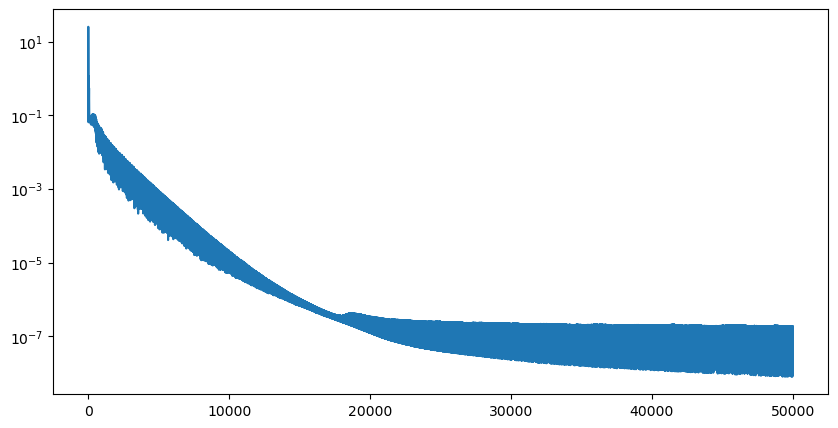

In [13]:
print(f"[Best][Epoch: {bep}] Train loss: {ls}") 
plt.figure(figsize=(10, 5))
plt.plot(loss_graph)
plt.yscale('log')
plt.show()

In [14]:
pinn.load_state_dict(torch.load('./'+eq+'_1d.pth'))

<All keys matched successfully>

In [15]:
t_test, x_test = lone_generator(256, 256, typ='test')
t = np.linspace(0, 1, 256).reshape(-1,1)
#print(np.linspace(0, 1, 101))
#print(t)
x = np.linspace(-1, 1, 256).reshape(-1,1)
#print('hi')
#print(x)
T = t.shape[0]
N = x.shape[0]
test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
print(test_variables.shape)

torch.Size([65536, 2])


torch.Size([65536, 1])


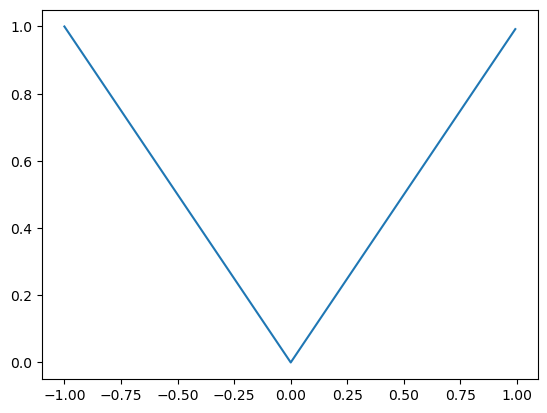

[[1.         0.9980397  0.99607944 ... 0.50392234 0.5019851  0.5000508 ]
 [0.99215686 0.9901965  0.9882361  ... 0.49612916 0.4941985  0.49227124]
 [0.9843137  0.98235327 0.9803928  ... 0.4883495  0.4864262  0.48450747]
 ...
 [0.9843137  0.9823529  0.9803922  ... 0.48829246 0.4863659  0.4844444 ]
 [0.99215686 0.99019605 0.9882353  ... 0.4960814  0.4941458  0.49221414]
 [1.         0.9980391  0.99607825 ... 0.50388694 0.50194335 0.5000033 ]]
L2 Relative Error: 0.13313829898834229


In [18]:
t_test, x_test = lone_generator(256, 256, typ='test')
t = np.linspace(0, 1, 256).reshape(-1,1)
#print(np.linspace(0, 1, 101))
#print(t)
x = np.linspace(-1, 1, 256).reshape(-1,1)
#print('hi')
#print(x)
T = t.shape[0]
N = x.shape[0]
test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
with torch.no_grad():
    u_pred = pinn(test_variables)
print(u_pred.shape)
u_pred = u_pred.cpu().numpy().reshape(N,T)

#print(u_pred.shape)
t_step = int(0.99*len(t))
#print(u_pred[:,t_step])
#plt.plot(x, u_pred[:,t_step],'--')
#plt.show()

# reference data
# def f(x):
#     if torch.absolute(x)<=1:
#         return 1/2*(x**2+t**2)
#     else:
#         return torch.absolute(x)+t-1/2


def f_l1(x,y):
    f = torch.zeros(256, 256)
    for j in range(len(y)):
        for i in range(len(x)):
            if torch.absolute(x[i])<y[j]:
                f[i,j] = 1/(2*y[j])*x[i]**2
            else:
                f[i,j] = torch.absolute(x[i])-y[j]/2
    return f

# function if initial function is x^2:
def f(x,y):
    f = torch.zeros(256, 256)
    for j in range(len(y)):
        for i in range(len(x)):
                f[i,j] = x[i]**2/(2*y[j]+1)
    return f
        
# def f(x):
#     f = []
#     for i in range(len(x[:,0])):
#         for j in range(len(x[:,1])):
#             if torch.absolute(x[i,0])<=x[j,1]:
#                 f.append(1/2*x[i,0]**2)
#             else:
#                 f.append(torch.absolute(x[i, 0])-x[j, 1]/2)
#     return f


interval_x = torch.arange(-1,1, 2/256)
# #print(interval_x)
interval_t = torch.arange(0,1, 1/256)
# #print(interval_t)

# interval = torch.stack((interval_x, interval_t), 1)
# print(interval)

#interval = torch.cartesian_prod(interval_x, interval_t)
#print(interval[0, 1])

#data = torch.tensor(list(map(f, interval_x, interval_t)))

data = f(interval_x, interval_t)

# data =  f(interval) 
# Exact = np.real(data['usol'])
  
Exact = data.cpu().numpy()

plt.plot(interval_x, Exact[:,0])
plt.show()

# print(u_pred)
# print(u_pred[:,:-1])
#err = u_pred[:,:-1]-Exact

print(u_pred)

err = err = u_pred-Exact

# f_0 = []
# for i in range(len(interval[:,0])):
#     for j in range(len(interval[:,1])):
#         if interval[j,1] == 0.5:
#             if torch.absolute(interval[i,0])<=interval[j,1]:
#                 f_0.append(1/2*interval[i,0]**2)
#             else:
#                 f_0.append(torch.absolute(interval[i, 0])-interval[j, 1]/2)
            
# print(f_0)

#print(err)

err = np.linalg.norm(err,2)/np.linalg.norm(data,2)   
print(f"L2 Relative Error: {err}")

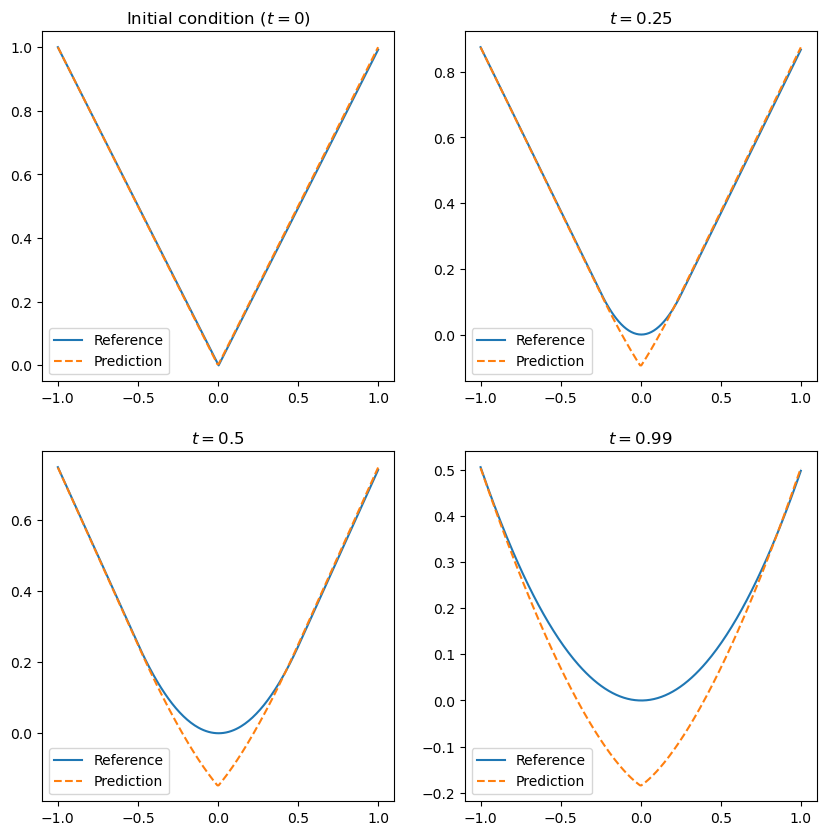

In [19]:
resplot(x, t, t_data, x_data, data, u_pred)

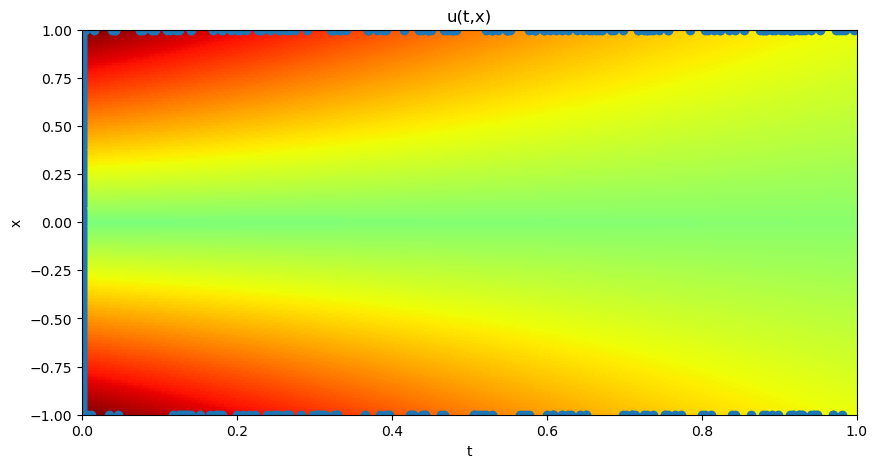

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
plt.clim(-1, 1)
plt.ylim(-1,1)
plt.xlim(0,1)
plt.scatter(t_data, x_data)
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()